<a href="https://colab.research.google.com/github/Tiya4425/Practice/blob/main/Genetic_Algorithm_RNN_windconsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Optimizing RNN using Genetic Algorithm 

#### Importing required packages

In [2]:
!pip install deap

     |████████████████████████████████| 160 kB 8.3 MB/s 


In [4]:
!pip install bitstring

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import LSTM, Input, Dense
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

np.random.seed(1120)

#### Reading dataset and using first 17,257 points as training/validation and rest of the 1500 points as test set.

In [10]:
data = pd.read_csv('train (3).csv')
data = np.reshape(np.array(data['wp1']),(len(data['wp1']),1))

train_data = data[0:17257]
test_data = data[17257:]

#### Defining Helper Functions

In [19]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_units == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    inputs = Input(shape=(window_size,1))
    x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    predictions = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',loss='mean_squared_error',validation_data=(X_val, y_val))
    model.fit(X_train, y_train, epochs=5, batch_size=10,shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

#### Genetic Representation of the Solution

<img src="genetic_representation.png" alt="Genetic representation of a solution">

#### Genetic Algorithm Overview

<img src="ga.png" alt="Genetic Algorithm">

In [12]:
population_size = 4
num_generations = 4
gene_length = 10

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)


Window Size:  36 , Num of Units:  2
Epoch 1/5
1378/1378 [==============================] - 15s 10ms/step - loss: 0.0267
Epoch 2/5
1378/1378 [==============================] - 15s 11ms/step - loss: 0.0093
Epoch 3/5
1378/1378 [==============================] - 13s 9ms/step - loss: 0.0069
Epoch 4/5
1378/1378 [==============================] - 13s 9ms/step - loss: 0.0059
Epoch 5/5
1378/1378 [==============================] - 13s 9ms/step - loss: 0.0057
Validation RMSE:  0.0767291238390496 


Window Size:  56 , Num of Units:  8
Epoch 1/5
1376/1376 [==============================] - 12s 8ms/step - loss: 0.0114
Epoch 2/5
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0061
Epoch 3/5
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0058
Epoch 4/5
1376/1376 [==============================] - 11s 8ms/step - loss: 0.0058
Epoch 5/5
1376/1376 [==============================] - 12s 8ms/step - loss: 0.0058
Validation RMSE:  0.07442871670842709 


Window Size:  

#### Print top N solutions - (1st only, for now)

In [13]:
best_individuals = tools.selBest(population,k = 1)
best_window_size = None
best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size, ', Num of Units: ', best_num_units)


Window Size:  63 , Num of Units:  9


#### Train the model using best configuration on complete training set and make predictions on the test set

In [21]:
X_train,y_train = prepare_dataset(train_data,best_window_size)
X_test, y_test = prepare_dataset(test_data,best_window_size)

inputs = Input(shape=(best_window_size,1))
x = LSTM(best_num_units, input_shape=(best_window_size,1))(inputs)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adam',loss='mean_squared_error')
history= model.fit(X_train, y_train, epochs=5, batch_size=10,shuffle=True,validation_data=(X_test, y_test))
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: ', rmse)

Epoch 1/5
1720/1720 [==============================] - 28s 15ms/step - loss: 0.0143 - val_loss: 0.0092
Epoch 2/5
1720/1720 [==============================] - 26s 15ms/step - loss: 0.0061 - val_loss: 0.0084
Epoch 3/5
1720/1720 [==============================] - 26s 15ms/step - loss: 0.0058 - val_loss: 0.0084
Epoch 4/5
1720/1720 [==============================] - 26s 15ms/step - loss: 0.0057 - val_loss: 0.0096
Epoch 5/5
1720/1720 [==============================] - 26s 15ms/step - loss: 0.0057 - val_loss: 0.0085
Test RMSE:  0.0920979507168481


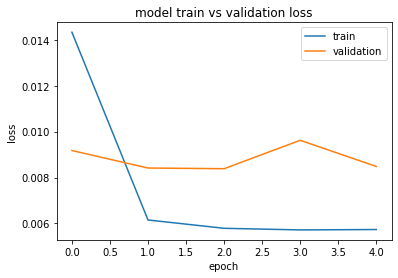

In [31]:
import matplotlib.pyplot as plt

#plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

http://aqibsaeed.github.io/2017-08-11-genetic-algorithm-for-optimizing-rnn/
dataset: https://www.kaggle.com/c/GEF2012-wind-forecasting/data?select=test.csv

https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

https://reader.elsevier.com/reader/sd/pii/S0169207013000745?token=EFB420529208226E2E215098E19E34C83FFABBAA6169324DD780369AE7329B1F9C195A43A8F3D19E9A24C6E32FCEB81D&originRegion=eu-west-1&originCreation=20220513131719
